# Roughness prediction using DNN

In [1]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import random
import hashlib
import pandas as pd
from tqdm import tqdm
import math
from sklearn.preprocessing import MinMaxScaler
import copy

# Data and preprocessing

In [2]:
class RandomHashFunction:
    def __init__(self, seed=None):
        self.seed = seed or random.randint(0, 2**32 - 1)
        random.seed(self.seed)
        self.salt = random.random()


    def forward(self, vector, min_val=0, max_val=10, output_type='float'):
        # if vector.shape != (6, ):
        #     raise ValueError("Only vector shape (1, 6)")
        # if output_type not in ['float', 'int']:
        #     raise ValueError("Unsupported type")

        # salted_tensor = vector + self.salt
        # input_str = ",".join(f"{x.item():.6f}" for x in salted_tensor.squeeze())
        # hashed_value = hashlib.sha256(input_str.encode()).hexdigest()

        # hashed_value = int(hashed_value, 16)
        # normalized = hashed_value / (2**256 - 1)

        # y = min_val + normalized * (max_val - min_val)

        # if output_type == 'int':
        #     return int(y)
        # elif output_type == 'float':
        #     return y

        y = math.sin(vector[0]) + math.cos(vector[1]) + math.sin(vector[2]) + math.cos(vector[3]) + math.sin(vector[4]) + math.cos(vector[5])
        normalized = 1 / (1 + math.exp(-y))

        # normalized = vector[0] + vector[1] + vector[2] + vector[3] + vector[4] + vector[5]
        # normalized = 1 / (1 + math.exp(-normalized))

        return min_val + normalized * (max_val - min_val)


class Dummy_data_generator:
    def __init__(self, num_samples=100, val_range=[0, 10], target = 'roughness',
                 feature_columns = ["Accel X (m/s^2)", "Accel Y", "Accel Z", "Rot_vel_X (m/s)", "Rot_vel_Y", "Rot_vel_Z"]):
        self.num_samples = num_samples
        self.feature_columns = feature_columns
        self.min_val = val_range[0]
        self.max_val = val_range[1]
        self.target = target

    def generate_target(self, vector):
        hash_function = RandomHashFunction()
        return hash_function.forward(vector, min_val=self.min_val, max_val=self.max_val)

    def generate_data_with_full_label(self):
        data = {i: np.random.uniform(-10, 10, self.num_samples) for i in self.feature_columns}

        data_matrix = np.array([data[col] for col in self.feature_columns]).T
        target_vals = [self.generate_target(row) for row in data_matrix]
        data[self.target] = target_vals
        return data


class SensorDataSet(Dataset):
    def __init__(self, dataframe):
        self.features = torch.tensor(dataframe.iloc[:, :-1].values, dtype=torch.float32)  # except last col
        self.targets = torch.tensor(dataframe.iloc[:, -1].values, dtype=torch.float32)   # only last col

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Model and training pipeline

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(6, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            # nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            # nn.BatchNorm1d(128),
            # nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x) ################################################################################################################################################


def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20, diplay_step=5, lr_scheduler=None):
    # model = copy.deepcopy(model)
    val_loss_history = []
    train_loss_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        num_data = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Training epooch {epoch+1}", leave=False):
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            if lr_scheduler is not None and epoch < 1:
                lr_scheduler.step()

            train_loss += loss.item()
            num_data += X_batch.shape[0]

            # print(train_loss)

        train_loss = train_loss / num_data
        train_loss_history.append(train_loss)
        # print(num_data)
        # exit()
        # evaluate
        val_loss = validate_model(model, criterion, val_loader)
        val_loss_history.append(val_loss)

        if (epoch+1)%diplay_step==0 or epoch==0:
            for param_group in optimizer.param_groups:
                lr = param_group['lr']

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, learning rate = {lr}")

    return train_loss_history, val_loss_history

def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    num_data = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
            num_data += X_batch.shape[0]

    return val_loss / num_data

# Train and evaluation

In [4]:
val_range=[0, 10]
generator = Dummy_data_generator(num_samples=6250, val_range=val_range)
data = generator.generate_data_with_full_label()
data = pd.DataFrame(data)
data

,Accel X (m/s^2),Accel Y,Accel Z,Rot_vel_X (m/s),Rot_vel_Y,Rot_vel_Z,roughness
0,2.238604,5.040030,6.381365,4.763932,0.408567,-0.137774,9.336621
1,4.083083,-9.698025,-2.702676,-2.386199,-8.373692,3.114423,0.082285
2,-1.975971,2.986898,-9.572873,-4.732590,-3.049799,-4.151275,0.860276
3,-0.971902,-6.311412,5.467249,-7.016911,-3.409804,5.692689,7.830672
4,-0.296194,-4.477946,9.518110,8.391337,-5.709381,-6.224312,6.015323
...,...,...,...,...,...,...,...
6245,6.412306,-3.975305,-5.014795,9.690612,4.162379,-2.808939,0.869610
6246,5.219391,5.487510,2.413914,-1.710141,3.085999,1.654365,5.802833
6247,1.491623,1.443208,-8.573704,6.579014,2.446582,-6.835977,9.437544
6248,6.632796,7.696557,7.170543,5.824394,-8.685948,-5.003115,8.562549


In [5]:
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(data, test_size=0.2, random_state=42)

train_set_ = SensorDataSet(train_set)
val_set_ = SensorDataSet(val_set)
# dataset = SensorDataSet(normalized_data)
batch_size = 256
train_loader = DataLoader(train_set_, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set_, batch_size=batch_size, shuffle=True)

In [6]:
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

In [7]:
validate_model(model, criterion, val_loader)

0.12528251953125

In [8]:
# data = train_set_
# # data = val_set_

# test_cases = []
# for i in range(10):
#     test_cases.append(random.randint(0, len(train_set)-1))
# for i in range(len(test_cases)):
#     print(train_set.iloc[i, :])

#     y = torch.tensor(train_set.iloc[i, -1], dtype=torch.float32)
#     x = np.array(train_set)[i, :-1]
#     x = torch.tensor(x, dtype=torch.float32)
#     x = x.unsqueeze(0)
#     print(f'predicted roughness by trained model: {model(x).item()}')
#     print(f'Error {criterion(model(x), y)}')
#     print()

Epoch 1/250, Train Loss: 0.0800, Val Loss: 0.0394, learning rate = 0.00049


Epoch 10/250, Train Loss: 0.0346, Val Loss: 0.0323, learning rate = 0.00049


Epoch 20/250, Train Loss: 0.0334, Val Loss: 0.0315, learning rate = 0.00049


Epoch 30/250, Train Loss: 0.0321, Val Loss: 0.0303, learning rate = 0.00049


Epoch 40/250, Train Loss: 0.0314, Val Loss: 0.0292, learning rate = 0.00049


Epoch 50/250, Train Loss: 0.0295, Val Loss: 0.0263, learning rate = 0.00049


Epoch 60/250, Train Loss: 0.0270, Val Loss: 0.0240, learning rate = 0.00049


Epoch 70/250, Train Loss: 0.0243, Val Loss: 0.0207, learning rate = 0.00049


Epoch 80/250, Train Loss: 0.0212, Val Loss: 0.0172, learning rate = 0.00049


Epoch 90/250, Train Loss: 0.0195, Val Loss: 0.0150, learning rate = 0.00049


Epoch 100/250, Train Loss: 0.0176, Val Loss: 0.0133, learning rate = 0.00049


Epoch 110/250, Train Loss: 0.0172, Val Loss: 0.0119, learning rate = 0.00049


Epoch 120/250, Train Loss: 0.0152, Val Loss: 0.0094, learning rate = 0.00049


Epoch 130/250, Train Loss: 0.0142, Val Loss: 0.0085, learning rate = 0.00049


Epoch 140/250, Train Loss: 0.0131, Val Loss: 0.0083, learning rate = 0.00049


Epoch 150/250, Train Loss: 0.0127, Val Loss: 0.0067, learning rate = 0.00049


Epoch 160/250, Train Loss: 0.0110, Val Loss: 0.0060, learning rate = 0.00049


Epoch 170/250, Train Loss: 0.0109, Val Loss: 0.0057, learning rate = 0.00049


Epoch 180/250, Train Loss: 0.0101, Val Loss: 0.0048, learning rate = 0.00049


Epoch 190/250, Train Loss: 0.0097, Val Loss: 0.0046, learning rate = 0.00049


Epoch 200/250, Train Loss: 0.0090, Val Loss: 0.0049, learning rate = 0.00049


Epoch 210/250, Train Loss: 0.0087, Val Loss: 0.0039, learning rate = 0.00049


Epoch 220/250, Train Loss: 0.0088, Val Loss: 0.0039, learning rate = 0.00049


Epoch 230/250, Train Loss: 0.0077, Val Loss: 0.0032, learning rate = 0.00049


Epoch 240/250, Train Loss: 0.0084, Val Loss: 0.0038, learning rate = 0.00049


Epoch 250/250, Train Loss: 0.0075, Val Loss: 0.0027, learning rate = 0.00049


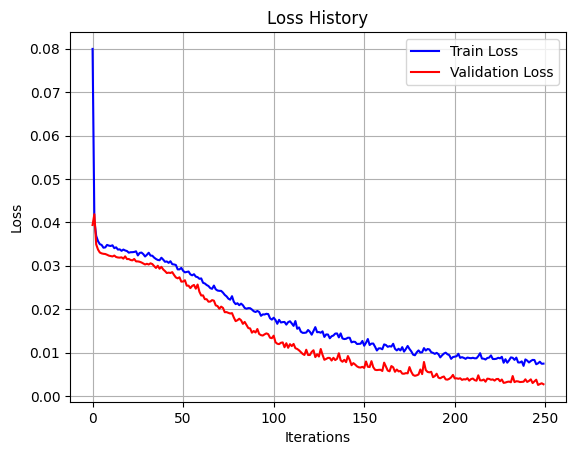

In [9]:
train_loss_history, val_loss_history = train_model(model, criterion, optimizer, train_loader, train_loader, epochs=250, diplay_step=10, lr_scheduler=lr_scheduler)

plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
torch.save(model.state_dict(),"trained_dnn.pth")

In [ ]:
validate_model(model, criterion, val_loader)

0.04042388000488281

In [ ]:
train_set

,Accel X (m/s^2),Accel Y,Accel Z,Rot_vel_X (m/s),Rot_vel_Y,Rot_vel_Z,roughness
1203,-7.377585,5.612114,-5.401589,0.846769,-6.015964,6.347676,9.302567
1740,0.651027,-0.975572,-1.413339,9.570378,3.421837,6.873364,4.363229
142,-8.373294,-2.584505,-9.397145,3.748019,0.594378,-9.829157,0.509010
2228,-0.861265,-3.147172,9.068362,0.536317,8.003700,-8.531346,4.531215
3922,-4.530640,0.791281,-5.737944,-3.895002,-3.067512,6.302216,9.169442
...,...,...,...,...,...,...,...
3772,-0.026300,6.987968,9.980883,0.184656,0.759488,-6.309529,9.467872
5191,-8.247362,7.263242,-6.052224,-4.757579,5.603889,-5.403717,4.792019
5226,8.498819,-2.881962,0.056707,7.796547,5.517593,-5.547353,4.987752
5390,0.368788,5.870053,-1.263218,7.166015,-3.060548,-9.960429,5.043395


In [ ]:
train_set_

In [ ]:
data = train_set_
# data = val_set_

test_cases = []
for i in range(10):
    test_cases.append(random.randint(0, len(train_set)-1))
for i in range(len(test_cases)):
    print(train_set.iloc[i, :])

    y = torch.tensor(train_set.iloc[i, -1], dtype=torch.float32)
    x = np.array(train_set)[i, :-1]
    x = torch.tensor(x, dtype=torch.float32)
    x = x.unsqueeze(0)
    print(f'predicted roughness by trained model: {model(x).item()}')
    print(f'Error {criterion(model(x), y)/ max(model(x).item(), y.item())*100: .2f} %')
    print()
# print(f'predicted roughness by untrained model: {untrained_model(x).item()}')

Accel X (m/s^2)   -7.377585
Accel Y            5.612114
Accel Z           -5.401589
Rot_vel_X (m/s)    0.846769
Rot_vel_Y         -6.015964
Rot_vel_Z          6.347676
roughness          9.302567
Name: 1203, dtype: float64
predicted roughness by trained model: 9.136096000671387
Error  0.30 %

Accel X (m/s^2)    0.651027
Accel Y           -0.975572
Accel Z           -1.413339
Rot_vel_X (m/s)    9.570378
Rot_vel_Y          3.421837
Rot_vel_Z          6.873364
roughness          4.363229
Name: 1740, dtype: float64
predicted roughness by trained model: 3.9597039222717285
Error  3.73 %

Accel X (m/s^2)   -8.373294
Accel Y           -2.584505
Accel Z           -9.397145
Rot_vel_X (m/s)    3.748019
Rot_vel_Y          0.594378
Rot_vel_Z         -9.829157
roughness          0.509010
Name: 142, dtype: float64
predicted roughness by trained model: 1.8348438739776611
Error  95.80 %

Accel X (m/s^2)   -0.861265
Accel Y           -3.147172
Accel Z            9.068362
Rot_vel_X (m/s)    0.536317
Rot_

## Summarization:
- Simple DNN can learn underlying relation in 6d data
- Relatively fast training with small dimensionality
- *Overfitting issue* hurts performance. Attempts:
    - Reduce model size
    - Add batchnorm, dropout
    - Increase batch_size
    - Learning rate scheduler (decaying)

## Future work:
- Test on real data
- Explore other architectures
- Physics-informed model (need some kinds of equation to describe the system)
- other regularization technique to improve generalization and robustness
- Finetunig hyperparameters (learning rate, model size, depth, etc.), architecture search for automatic finetuning.


# Concerns:
- Regarding simulation: Tool for simulation (Simulink, MATLAB, labview, ROS, etc)? How can we attain the Robot arm and surface model (for simulation)?
- Which kind of controller we plan to use for our system??
- How can we actually integrate trained DNN to our simulation (some available refernces ? ) ??
